# TGAS RAVE sample
Summary plots of a TGAS-RAVE sample from the EDF using a hybrid completeness map -- for $I<8$ we use NSIDE=4 map and $I>8$ NSIDE=32.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_palette('Set2')

## RAVE DR4 data
Load in RAVE DR4 data with Tycho magnitudes, cut those not in Tycho 2. Compute Galactic coords, I band magnitude and DR5 metallicities.

In [2]:
tychoData = pd.read_csv('/data/jls/TGAS/rave_distances_all.csv')
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=tychoData['RA'].values*u.degree, dec=tychoData['DEC'].values*u.degree,frame='fk5')
f=c.transform_to('galactic')
tychoData['l']=f.l
tychoData['b']=f.b
tychoData = tychoData[(np.fabs(tychoData.b)>5.)&(tychoData.DEC<0.)].reset_index(drop=True)
tychoData['vphi_tmp'] = tychoData['vphi']

## Mock data
Load mock data and compute RA,Dec in degrees for later

In [3]:
mocktychoData = pd.read_csv('/data/jls/edf/Tycho2_sample/full_sample_TYCHO2RAVE.csv')
mocktychoData['RAdeg'] = np.rad2deg(mocktychoData.RA.values)
mocktychoData['DECdeg'] = np.rad2deg(mocktychoData.DEC.values)

In [4]:
print 'There are %i Tycho 2 stars and %i mock Tycho 2 stars.' % (len(tychoData),len(mocktychoData))
print 'Downsampling...'
mocktychoData = mocktychoData.loc[np.random.choice(np.arange(len(mocktychoData)),size=len(tychoData),replace=False)]
print 'There are %i Tycho 2 stars and %i mock Tycho 2 stars.' % (len(tychoData),len(mocktychoData))

There are 203491 Tycho 2 stars and 500000 mock Tycho 2 stars.
Downsampling...
There are 203491 Tycho 2 stars and 203491 mock Tycho 2 stars.


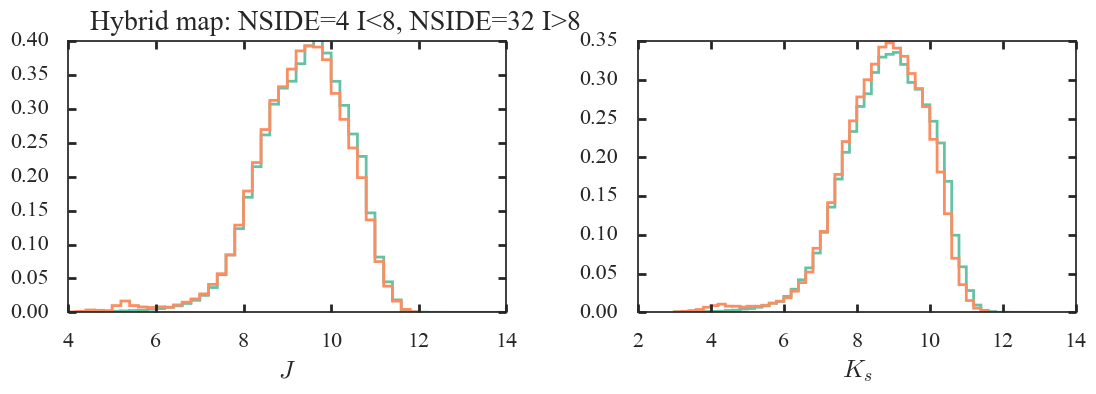

In [5]:
f,a=plt.subplots(1,2,figsize=[13.,3.5])
plt.subplots_adjust(wspace=0.3)
histargs = {'bins':50,'histtype':'step','normed':True,'lw':2}
x = a[0].hist(tychoData.J,range=[4.,14.],**histargs)
x = a[0].hist(mocktychoData.J.values,range=[4.,14.],**histargs)
a[0].set_xlabel(r'$J$')
x = a[1].hist(tychoData.K,range=[3.,13.],label='Data',**histargs)
x = a[1].hist(mocktychoData.K.values,range=[3.,13.],label='Mock',**histargs)
a[1].set_xlabel(r'$K_s$')
a[0].annotate('Hybrid map: NSIDE=4 I<8, NSIDE=32 I>8',xy=(0.05,1.02),xycoords='axes fraction',ha='left',
              va='bottom',fontsize=20)

In [6]:
def contour2D(data,cols,axis,ranges=None,bins=40,with_imshow=False,with_contours=True,
              label=None,fabsflag=False,text=None,cmap=plt.cm.hot,with_kde=False,
              kde_bandwidth=0.01,alpha=1.,log=False,ncontours=5,minz=None,vminmax=None):
    ''' Plots 2D histogram of data[cols[0]] against data[cols[1]]
        with the option of underlaying with filled contour '''
    ydata = data[cols[1]]
    xdata = data[cols[0]]
    if(fabsflag):
        xdata = np.fabs(ydata)
    h2,x,y = np.histogram2d(xdata,ydata,bins=bins,range=ranges,normed=True)

    ex = [x[0],x[-1],y[0],y[-1]]
    if(with_kde):
        X, Y = np.mgrid[x[0]:x[-1]:100j, y[0]:y[-1]:50j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        values = np.vstack([xdata,ydata])
        kernel = stats.gaussian_kde(values)
        h2 = np.reshape(kernel(positions).T, X.shape)
    if(with_imshow==False and with_contours==False):
        print 'Need to plot either contours or image or both in contour2D'
    if(with_imshow):
        htmp=np.rot90(h2/np.max(h2))
        if(log==True):
            htmp=np.log10(htmp)
        vmin,vmax=0.,1.
        if(vminmax):
            vmin=vminmax[0]
            vmax=vminmax[1]
        elif(log==True):
            vmin,vmax=-3.,0.
        if(minz):
            vmin=minz
        c = axis.imshow(htmp,cmap=cmap,extent=ex,clip_on=False,aspect='auto',vmin=vmin,vmax=vmax,alpha=alpha,interpolation='bicubic')
    if(with_contours):
        htmp=h2/np.max(h2)
        if(log==True):
            htmp=-np.log10(htmp)
        c = axis.contour(.5*(x[1:]+x[:-1]),.5*(y[1:]+y[:-1]),htmp.T,
                     origin='lower',
                     colors=[sns.color_palette()[0+2*with_imshow]],
                     label=label,
                     contours=ncontours)
    if(text):
        axis.annotate(text, xy=(0.02, 0.98),
                      xycoords='axes fraction',
                      fontsize=24,
                      horizontalalignment='left',
                      verticalalignment='top',
                      color='white')
    return c,(h2,ex)

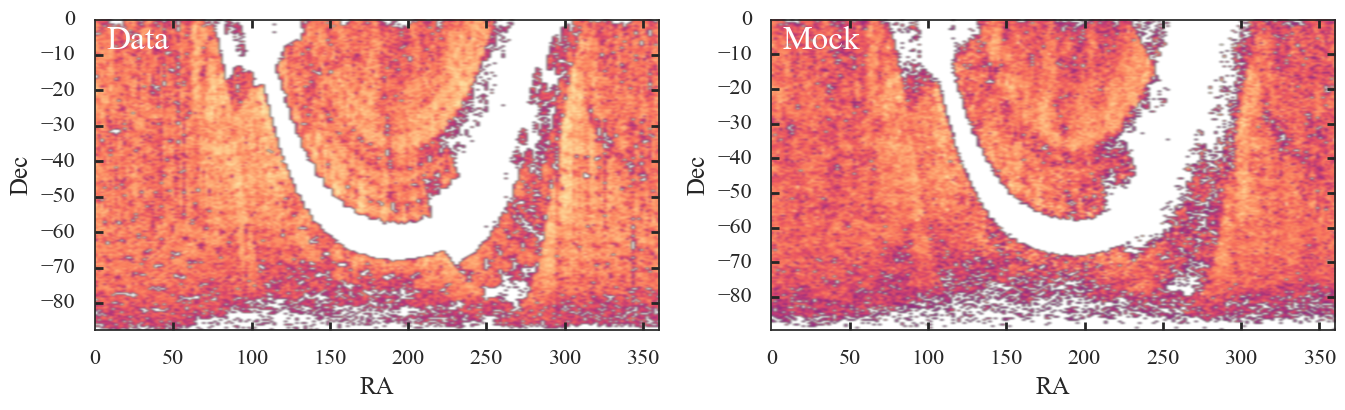

In [7]:
f,a=plt.subplots(1,2,figsize=[16.,4.])
x = contour2D(tychoData,['RA','DEC'],a[0],with_imshow=True,log=True,bins=200,vminmax=[-3.,0.],
              with_contours=False,cmap=plt.cm.magma,text='Data')
x = contour2D(mocktychoData,['RAdeg','DECdeg'],a[1],with_imshow=True,log=True,bins=200,vminmax=[-3.,0.],
              with_contours=False,cmap=plt.cm.magma,text='Mock')
for i in range(2):
    a[i].set_xlabel('RA')
    a[i].set_ylabel('Dec')
#     a[i].set_ylim(-90.,0.)

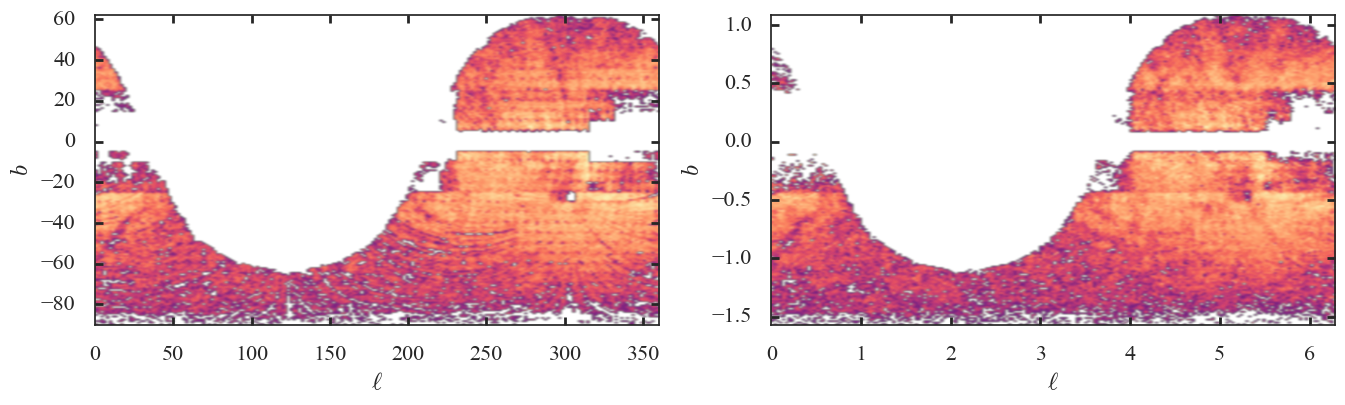

In [8]:
f,a=plt.subplots(1,2,figsize=[16.,4.])
x = contour2D(tychoData,['l','b'],a[0],with_imshow=True,log=True,bins=200,with_contours=False,cmap=plt.cm.magma,text='Data')
x = contour2D(mocktychoData,['l','b'],a[1],with_imshow=True,log=True,bins=200,with_contours=False,cmap=plt.cm.magma,text='Mock')
for i in range(2):
    a[i].set_xlabel(r'$\ell$')
    a[i].set_ylabel(r'$b$')

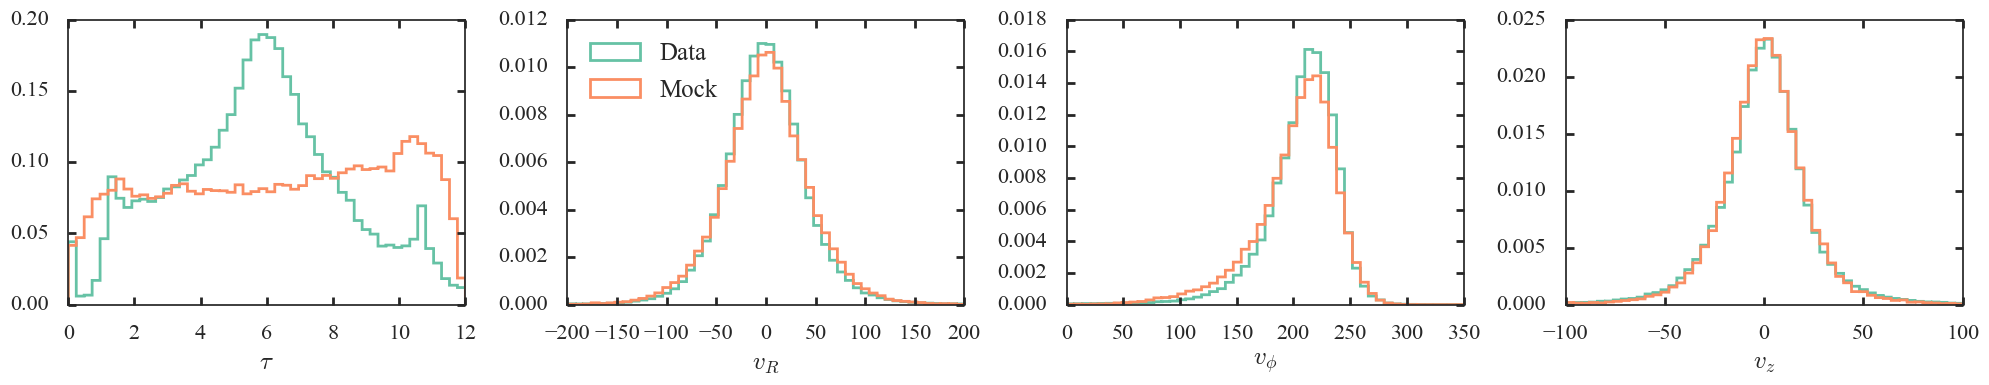

In [9]:
f,a=plt.subplots(1,4,figsize=[20.,4.])
lbls=[r'$\tau$',r'$v_R$',r'$v_\phi$',r'$v_z$']
ranges=[[0.,12.],[-200.,200.],[0.,350.],[-100.,100.]]
tychoData['age']=tychoData['AGE_Padova']
tychoData['vphi']=tychoData['vphi_tmp']-20. ## Here we difference as model was created with Vc=220 and data used Vc=240
for k,(l,rr,lbl) in enumerate(zip(['age','vR','vphi','vz'],ranges,lbls)):
    x = a[k].hist(tychoData[l].values,color=sns.color_palette()[0],label='Data',range=rr,**histargs)
    x = a[k].hist(mocktychoData[l].values,color=sns.color_palette()[1],label='Mock',range=rr,**histargs)
    a[k].set_xlabel(lbl)
a[1].legend(loc=2)
plt.tight_layout()

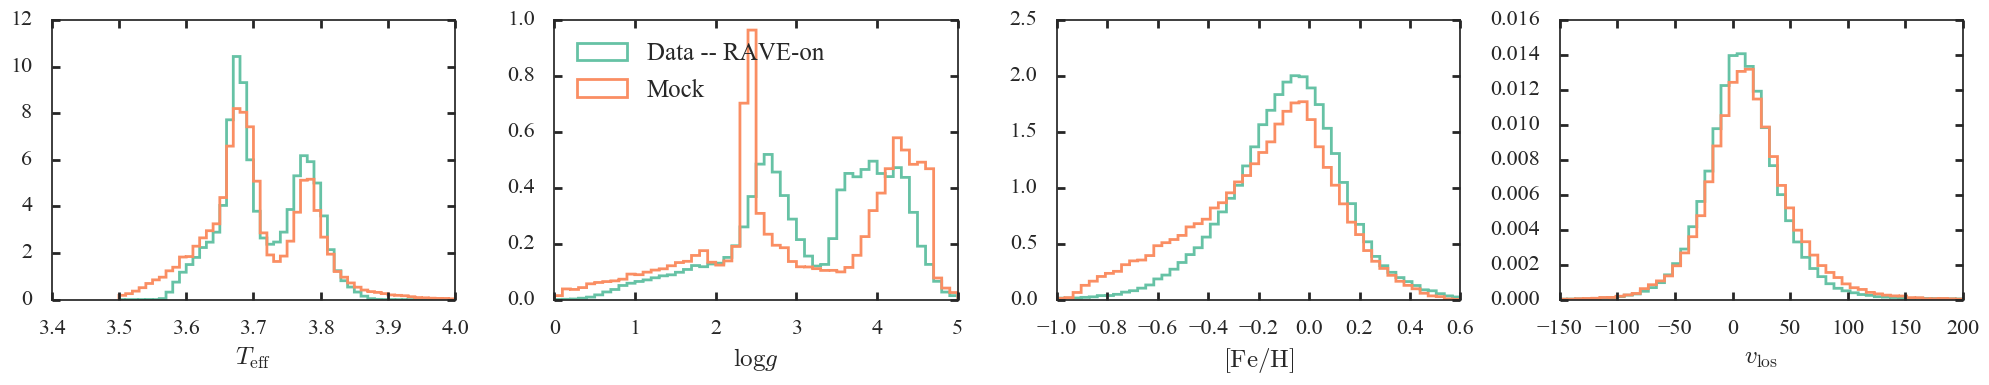

In [10]:
f,a=plt.subplots(1,4,figsize=[20.,4.])
lbls=[r'$T_\mathrm{eff}$',r'$\log g$',r'$[\mathrm{Fe}/\mathrm{H}]$',r'$v_\mathrm{los}$']
tychoData['Teff']=np.log10(tychoData.TEFF)
ranges=[[3.5,4.],[0.,5.],[-1.,0.6],[-150.,200.]]
for k,(l,m,rr,lbl) in enumerate(zip(['Teff','logg','Z','vlos'],['Teff','LOGG','FE_H','RV'],ranges,lbls)):
    x = a[k].hist(tychoData[m].values,range=rr,label='Data -- RAVE-on',**histargs)
    x = a[k].hist(mocktychoData[l].values,range=rr,label='Mock',**histargs)
    a[k].set_xlabel(lbl)
a[1].legend(loc=2)
plt.tight_layout()

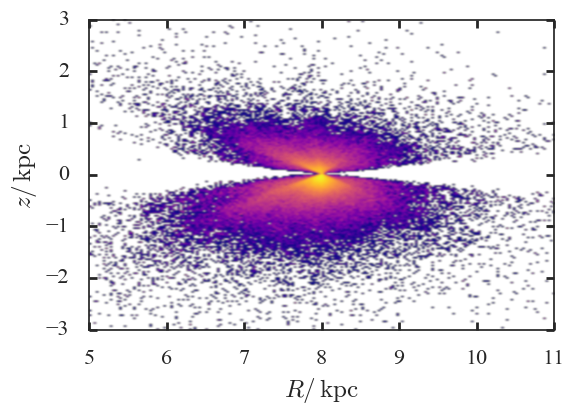

In [11]:
g = contour2D(mocktychoData,['R','z'],plt.gca(),ranges=[[5.,11.],[-3.,3.]],
              with_imshow=True,log=True,bins=200,with_contours=False,cmap=plt.cm.plasma)
plt.xlabel(r'$R/\,\mathrm{kpc}$')
plt.ylabel(r'$z/\,\mathrm{kpc}$')

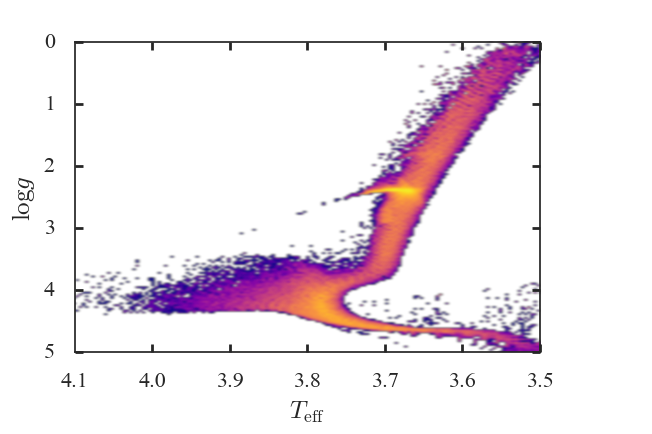

In [12]:
g = contour2D(mocktychoData,['Teff','logg'],plt.gca(),
              with_imshow=True,log=True,bins=200,with_contours=False,cmap=plt.cm.plasma)
plt.xlim(4.1,3.5)
plt.ylim(5.,0.)
plt.xlabel(r'$T_\mathrm{eff}$')
plt.ylabel(r'$\log g$')

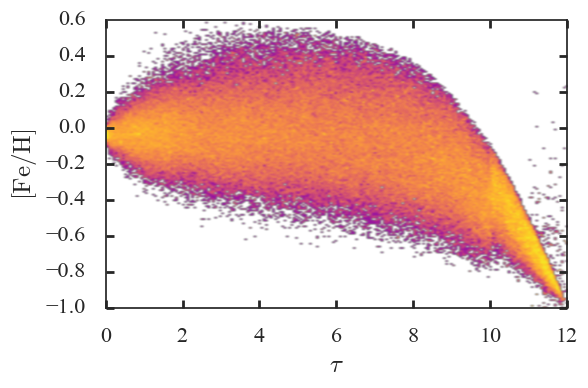

In [17]:
g = contour2D(mocktychoData,['age','Z'],plt.gca(),ranges=[[0.,12.],[-1.,.6]],
              with_imshow=True,log=True,bins=200,with_contours=False,cmap=plt.cm.plasma)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$[\mathrm{Fe}/\mathrm{H}]$')
plt.tight_layout()

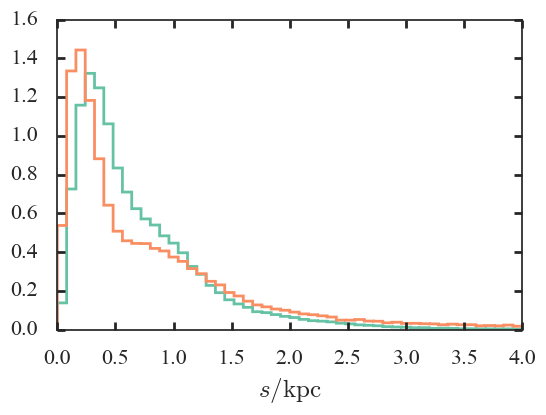

In [28]:
xx=plt.hist(tychoData.s.values,range=[0.,4.],**histargs)
xx=plt.hist(mocktychoData.s.values,range=[0.,4.],**histargs)
plt.xlabel(r'$s/\mathrm{kpc}$')